In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gaussian_kde

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, f1_score, accuracy_score, classification_report, confusion_matrix


from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE



colors = ['#011f4b', '#03396c', '#005b96', '#6497b1', '#b3cde0']

In [4]:
df = pd.read_csv("heart_attack_prediction_indonesia.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158355 entries, 0 to 158354
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   age                             158355 non-null  int64  
 1   gender                          158355 non-null  object 
 2   region                          158355 non-null  object 
 3   income_level                    158355 non-null  object 
 4   hypertension                    158355 non-null  int64  
 5   diabetes                        158355 non-null  int64  
 6   cholesterol_level               158355 non-null  int64  
 7   obesity                         158355 non-null  int64  
 8   waist_circumference             158355 non-null  int64  
 9   family_history                  158355 non-null  int64  
 10  smoking_status                  158355 non-null  object 
 11  alcohol_consumption             63507 non-null   object 
 12  physical_activit

In [5]:
numeric_cols = [
    'age', 'cholesterol_level', 'waist_circumference', 'blood_pressure_systolic',
    'blood_pressure_diastolic', 'sleep_hours', 'fasting_blood_sugar',
    'cholesterol_hdl', 'cholesterol_ldl', 'triglycerides'
]

nominal_cols = [
    'gender', 'region', 'income_level', 'smoking_status',
    'physical_activity', 'dietary_habits', 'air_pollution_exposure', 'stress_level', 'EKG_results',
    'hypertension', 'diabetes', 'obesity', 'family_history', 'previous_heart_disease',
    'medication_usage', 'participated_in_free_screening', 'heart_attack'
]

print(f"Number of Numeric Columns: {len(numeric_cols)}")
print(f"Number of Nominal Columns: {len(nominal_cols)}")

print(f"\nNumeric Columns:")
print(numeric_cols)

print(f"\nNominal Columns:")
print(nominal_cols)

Number of Numeric Columns: 10
Number of Nominal Columns: 17

Numeric Columns:
['age', 'cholesterol_level', 'waist_circumference', 'blood_pressure_systolic', 'blood_pressure_diastolic', 'sleep_hours', 'fasting_blood_sugar', 'cholesterol_hdl', 'cholesterol_ldl', 'triglycerides']

Nominal Columns:
['gender', 'region', 'income_level', 'smoking_status', 'physical_activity', 'dietary_habits', 'air_pollution_exposure', 'stress_level', 'EKG_results', 'hypertension', 'diabetes', 'obesity', 'family_history', 'previous_heart_disease', 'medication_usage', 'participated_in_free_screening', 'heart_attack']


C:\Users\namvi\AppData\Local\Temp\ipykernel_26096\1418859959.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette=sns.color_palette(colors[:3]))
C:\Users\namvi\AppData\Local\Temp\ipykernel_26096\1418859959.py:4: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.countplot(data=df, x=col, palette=sns.color_palette(colors[:3]))
C:\Users\namvi\AppData\Local\Temp\ipykernel_26096\1418859959.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette=sns.color_palette(colors[:3]))
C:\Users\namvi\AppData\Local\Temp\ipykernel_26096\1418859959.py:4: UserWarning: The palette list has more values (3) than need

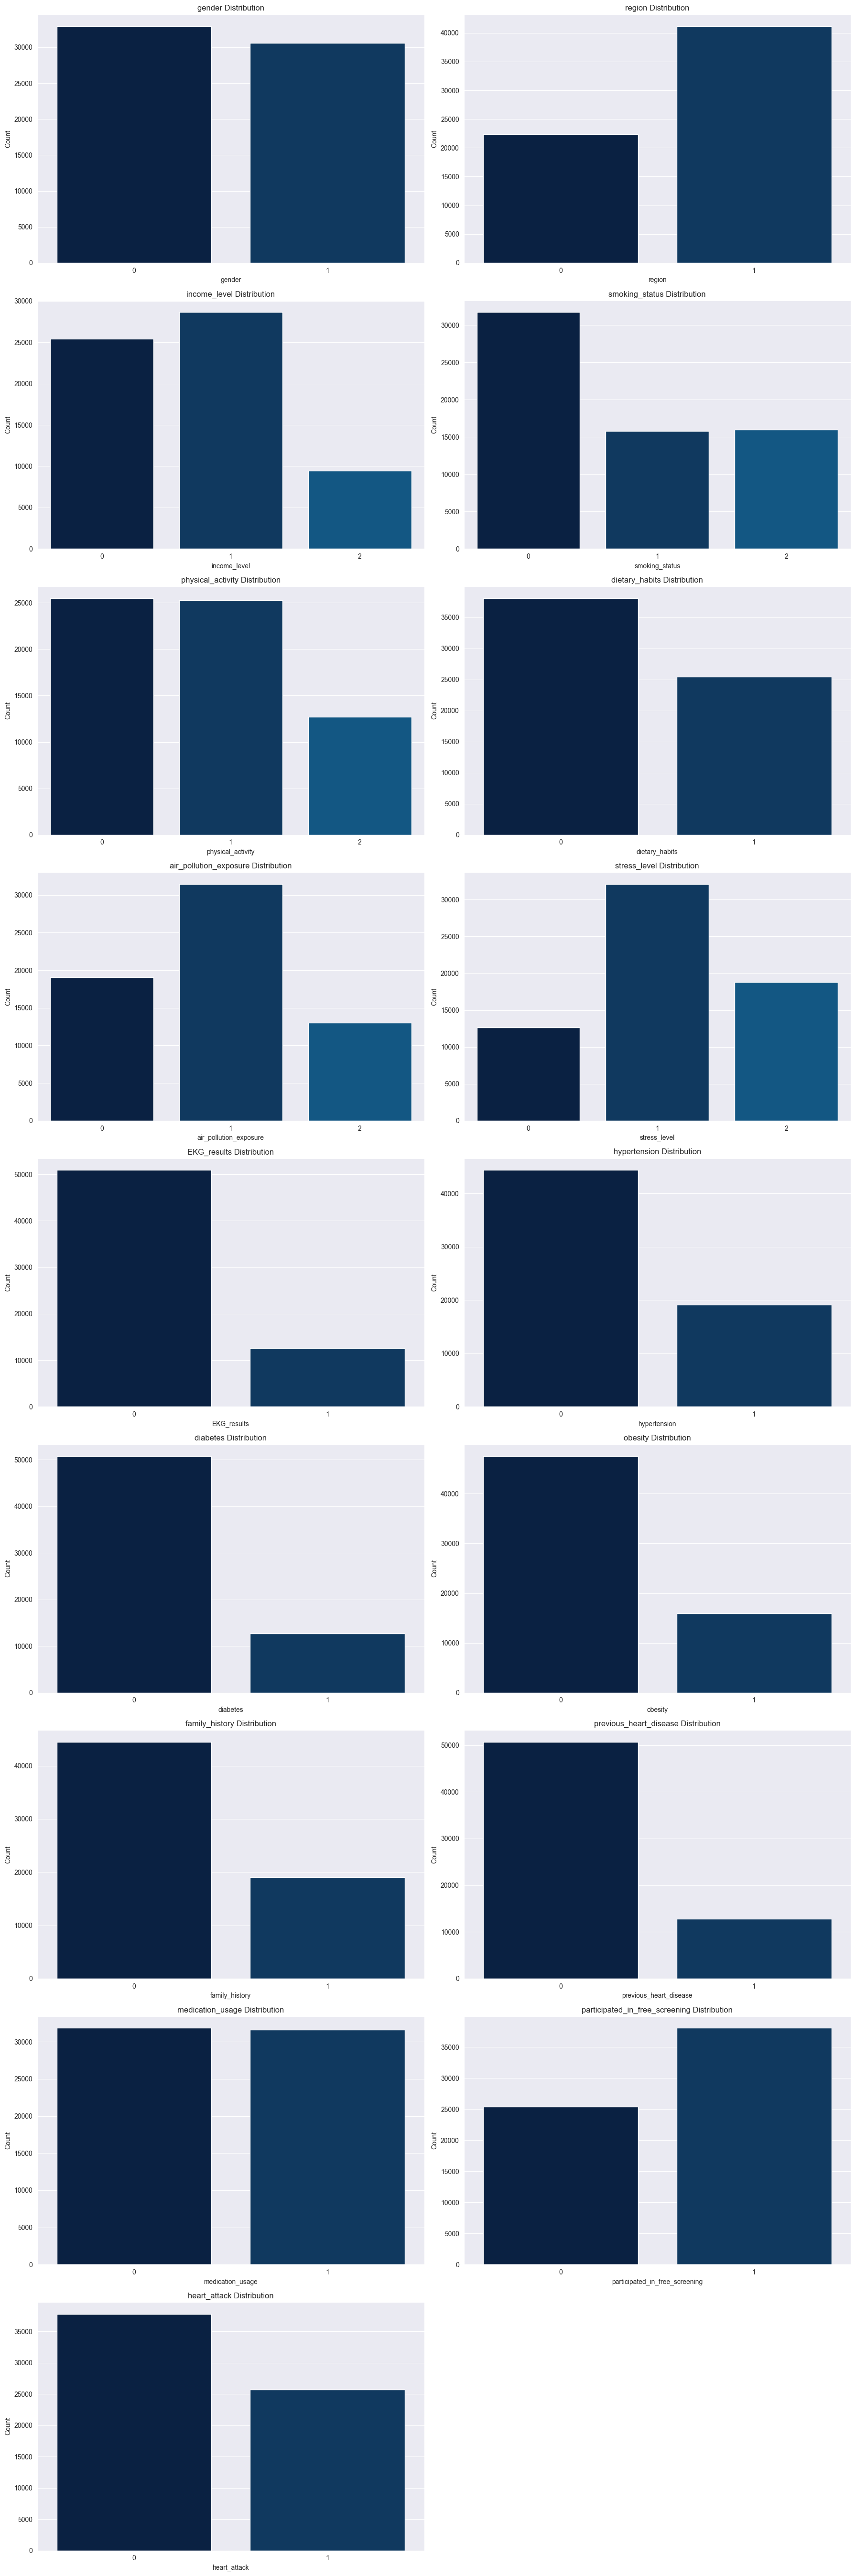

In [29]:
plt.figure(figsize=(18, 54))
for idx, col in enumerate(nominal_cols, 1):
    plt.subplot(9, 2, idx)
    sns.countplot(data=df, x=col, palette=sns.color_palette(colors[:3]))
    plt.title(f"{col} Distribution")
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

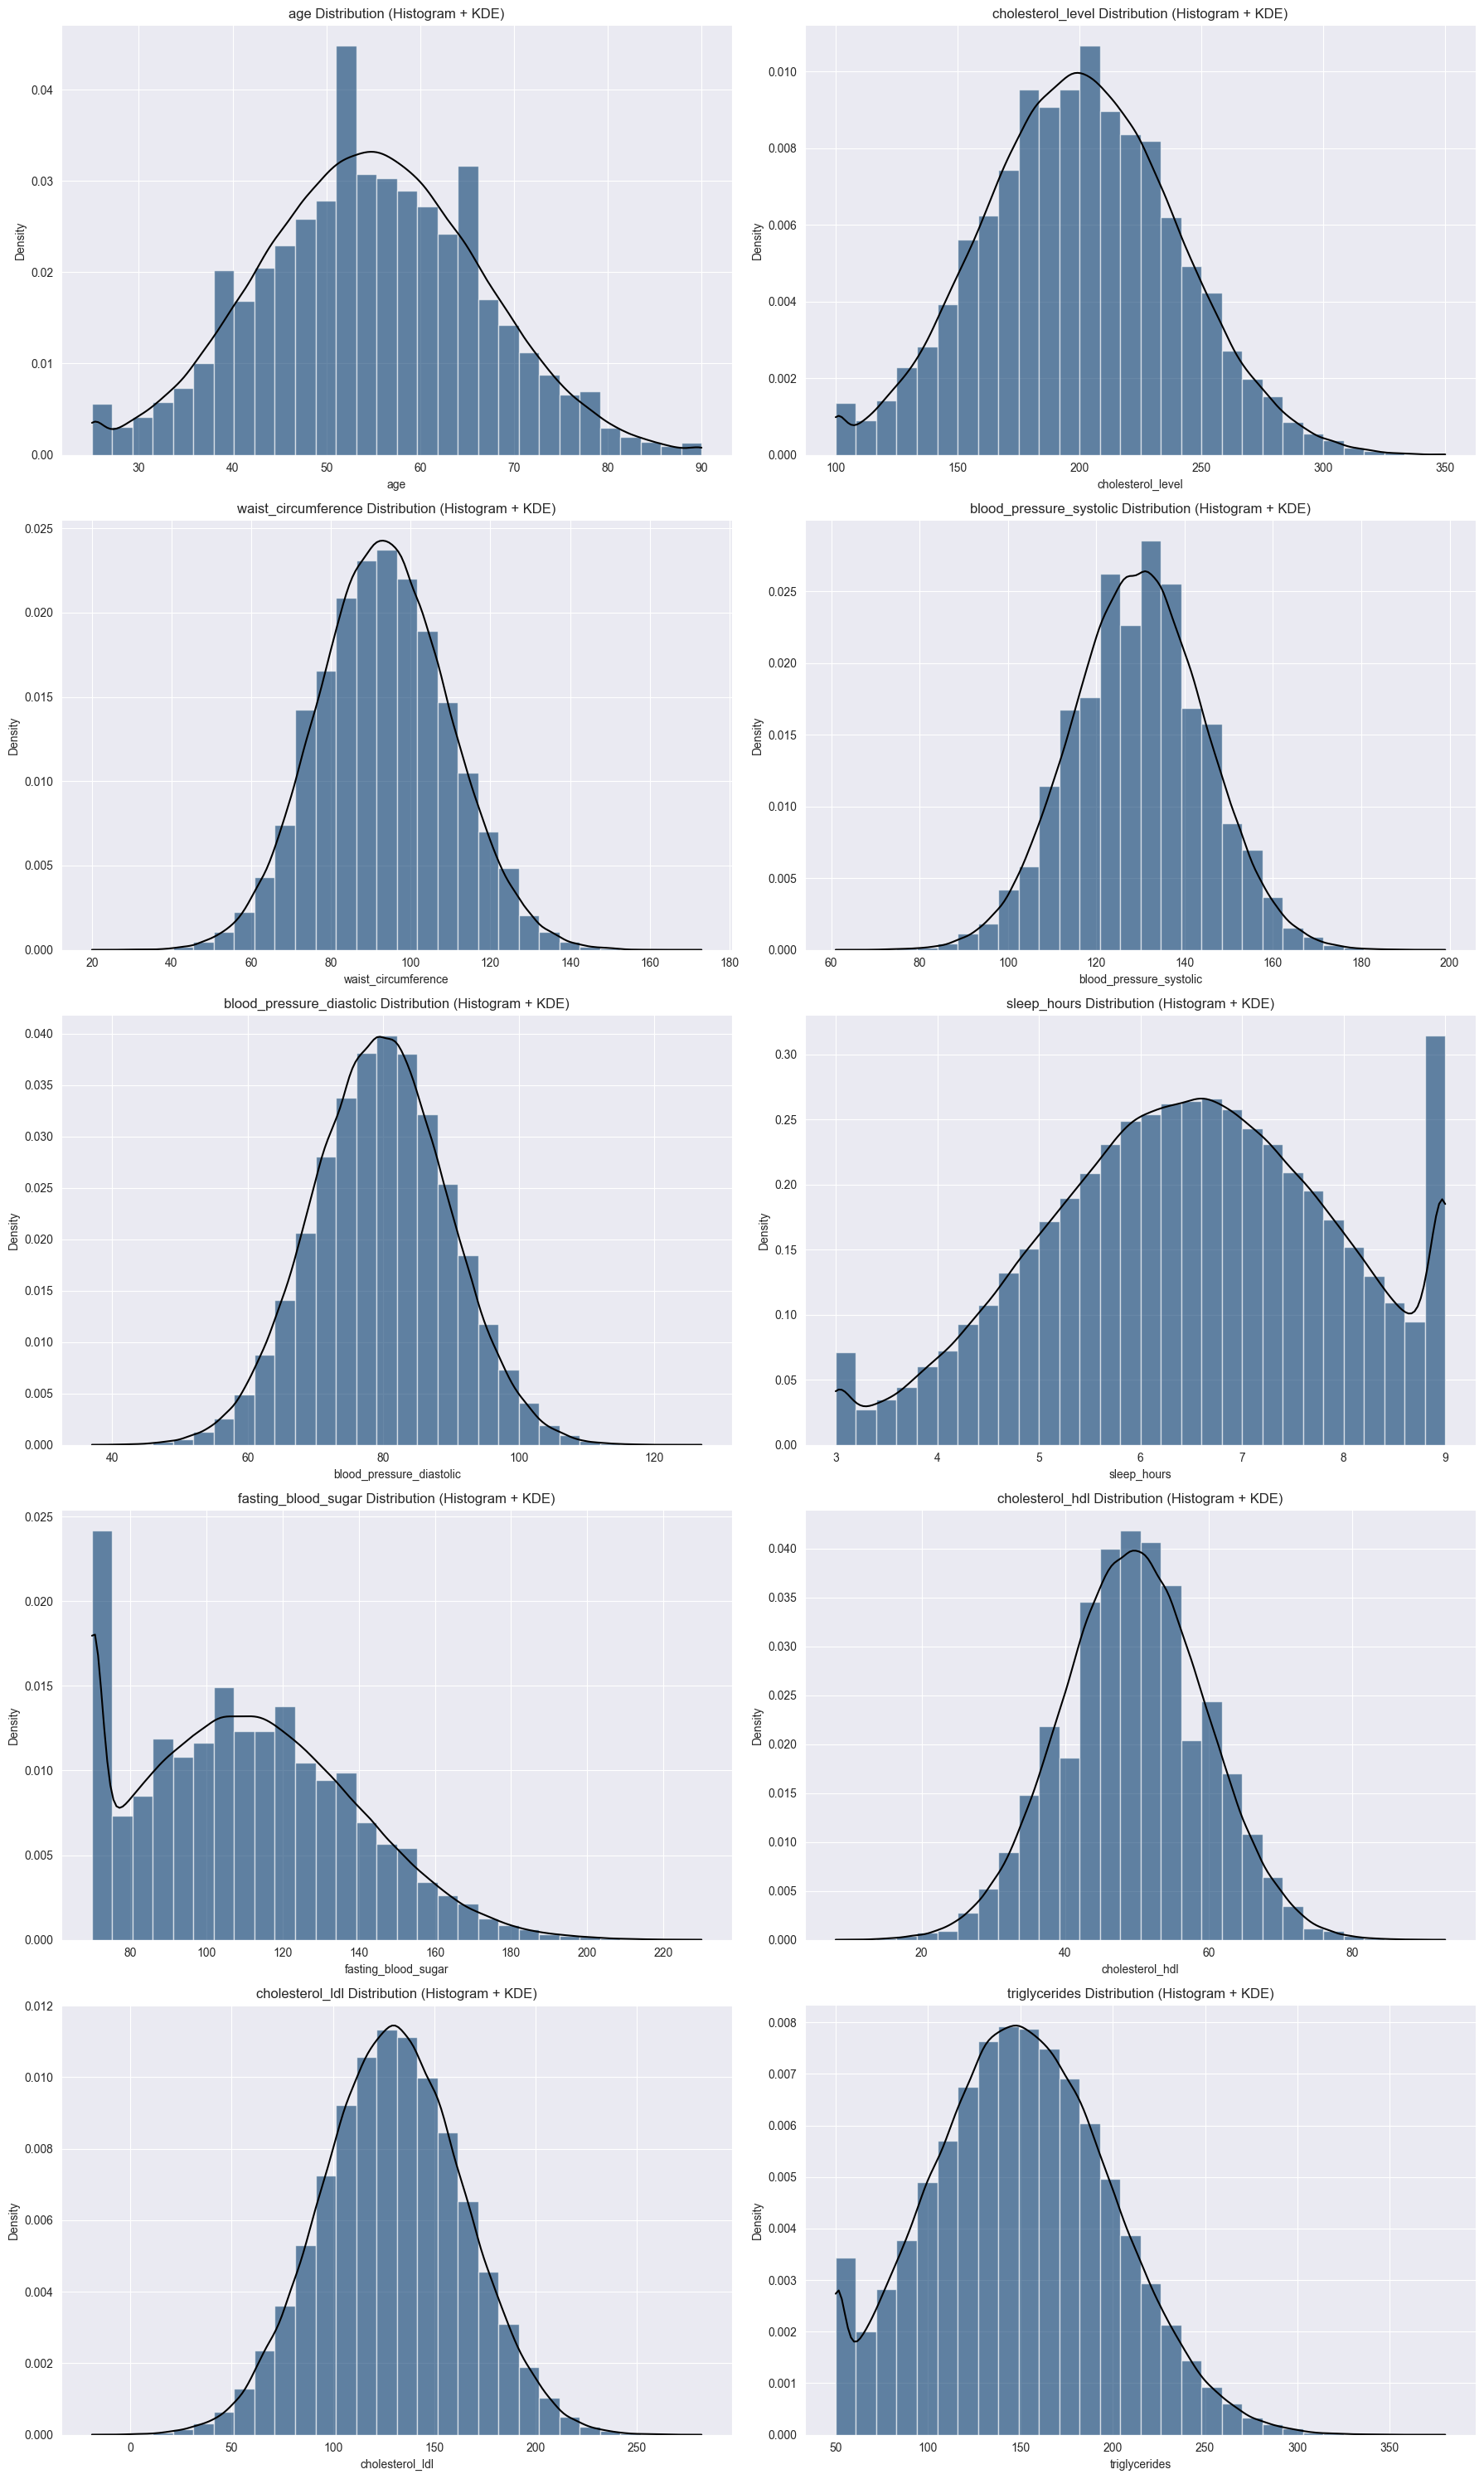

In [7]:
clean_numeric_df = df[numeric_cols].replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(18, 30))
for idx, col in enumerate(numeric_cols, 1):
    data = clean_numeric_df[col].dropna()

    plt.subplot(5, 2, idx)
    plt.hist(data, bins=30, color=colors[1], alpha=0.6, density=True)
    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 200)
    plt.plot(x_vals, kde(x_vals), color='black')
    plt.title(f"{col} Distribution (Histogram + KDE)")
    plt.xlabel(col)
    plt.ylabel('Density')

plt.tight_layout()


In [8]:
label_maps = {
    'gender': {'Male': 0, 'Female': 1},
    'region': {'Rural': 0, 'Urban': 1},
    'income_level': {'Low': 0, 'Middle': 1, 'High': 2},
    'smoking_status': {'Never': 0, 'Past': 1, 'Current': 2},
    'physical_activity': {'Low': 0, 'Moderate': 1, 'High': 2},
    'dietary_habits': {'Unhealthy': 0, 'Healthy': 1},
    'air_pollution_exposure': {'Low': 0, 'Moderate': 1, 'High': 2},
    'stress_level': {'Low': 0, 'Moderate': 1, 'High': 2},
    'EKG_results': {'Normal': 0, 'Abnormal': 1},
    'alcohol_consumption': {'None': 0, 'Moderate': 1, 'High': 2}
}


for col, mapping in label_maps.items():
    df[col] = df[col].map(mapping)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158355 entries, 0 to 158354
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   age                             158355 non-null  int64  
 1   gender                          158355 non-null  int64  
 2   region                          158355 non-null  int64  
 3   income_level                    158355 non-null  int64  
 4   hypertension                    158355 non-null  int64  
 5   diabetes                        158355 non-null  int64  
 6   cholesterol_level               158355 non-null  int64  
 7   obesity                         158355 non-null  int64  
 8   waist_circumference             158355 non-null  int64  
 9   family_history                  158355 non-null  int64  
 10  smoking_status                  158355 non-null  int64  
 11  alcohol_consumption             63507 non-null   float64
 12  physical_activit

In [9]:
df_clean = df.copy()
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.dropna(inplace=True)
df = df_clean.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63507 entries, 2 to 158352
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             63507 non-null  int64  
 1   gender                          63507 non-null  int64  
 2   region                          63507 non-null  int64  
 3   income_level                    63507 non-null  int64  
 4   hypertension                    63507 non-null  int64  
 5   diabetes                        63507 non-null  int64  
 6   cholesterol_level               63507 non-null  int64  
 7   obesity                         63507 non-null  int64  
 8   waist_circumference             63507 non-null  int64  
 9   family_history                  63507 non-null  int64  
 10  smoking_status                  63507 non-null  int64  
 11  alcohol_consumption             63507 non-null  float64
 12  physical_activity               6350

In [10]:
df['bp_ratio'] = df['blood_pressure_systolic'] / df['blood_pressure_diastolic']
df['sugar_triglyceride_ratio'] = df['fasting_blood_sugar'] / (df['triglycerides'] + 1)
df['hdl_ldl_ratio'] = df['cholesterol_hdl'] / (df['cholesterol_ldl'] + 1)
df['non_hdl_cholesterol'] = df['cholesterol_level'] - df['cholesterol_hdl']
df['waist_age_ratio'] = df['waist_circumference'] / (df['age'] + 1)
df['stress_sleep_ratio'] = df['stress_level'] / (df['sleep_hours'] + 0.1)
df['metabolic_index'] = (df['fasting_blood_sugar'] + df['triglycerides'] + df['cholesterol_ldl']) / 3
df['cholesterol_density'] = df['cholesterol_level'] / (df['waist_circumference'] + 1)

In [11]:
derived_cols = [
    'bp_ratio',
    'sugar_triglyceride_ratio',
    'hdl_ldl_ratio',
    'non_hdl_cholesterol',
    'waist_age_ratio',
    'stress_sleep_ratio',
    'cholesterol_density',
    'metabolic_index'
]

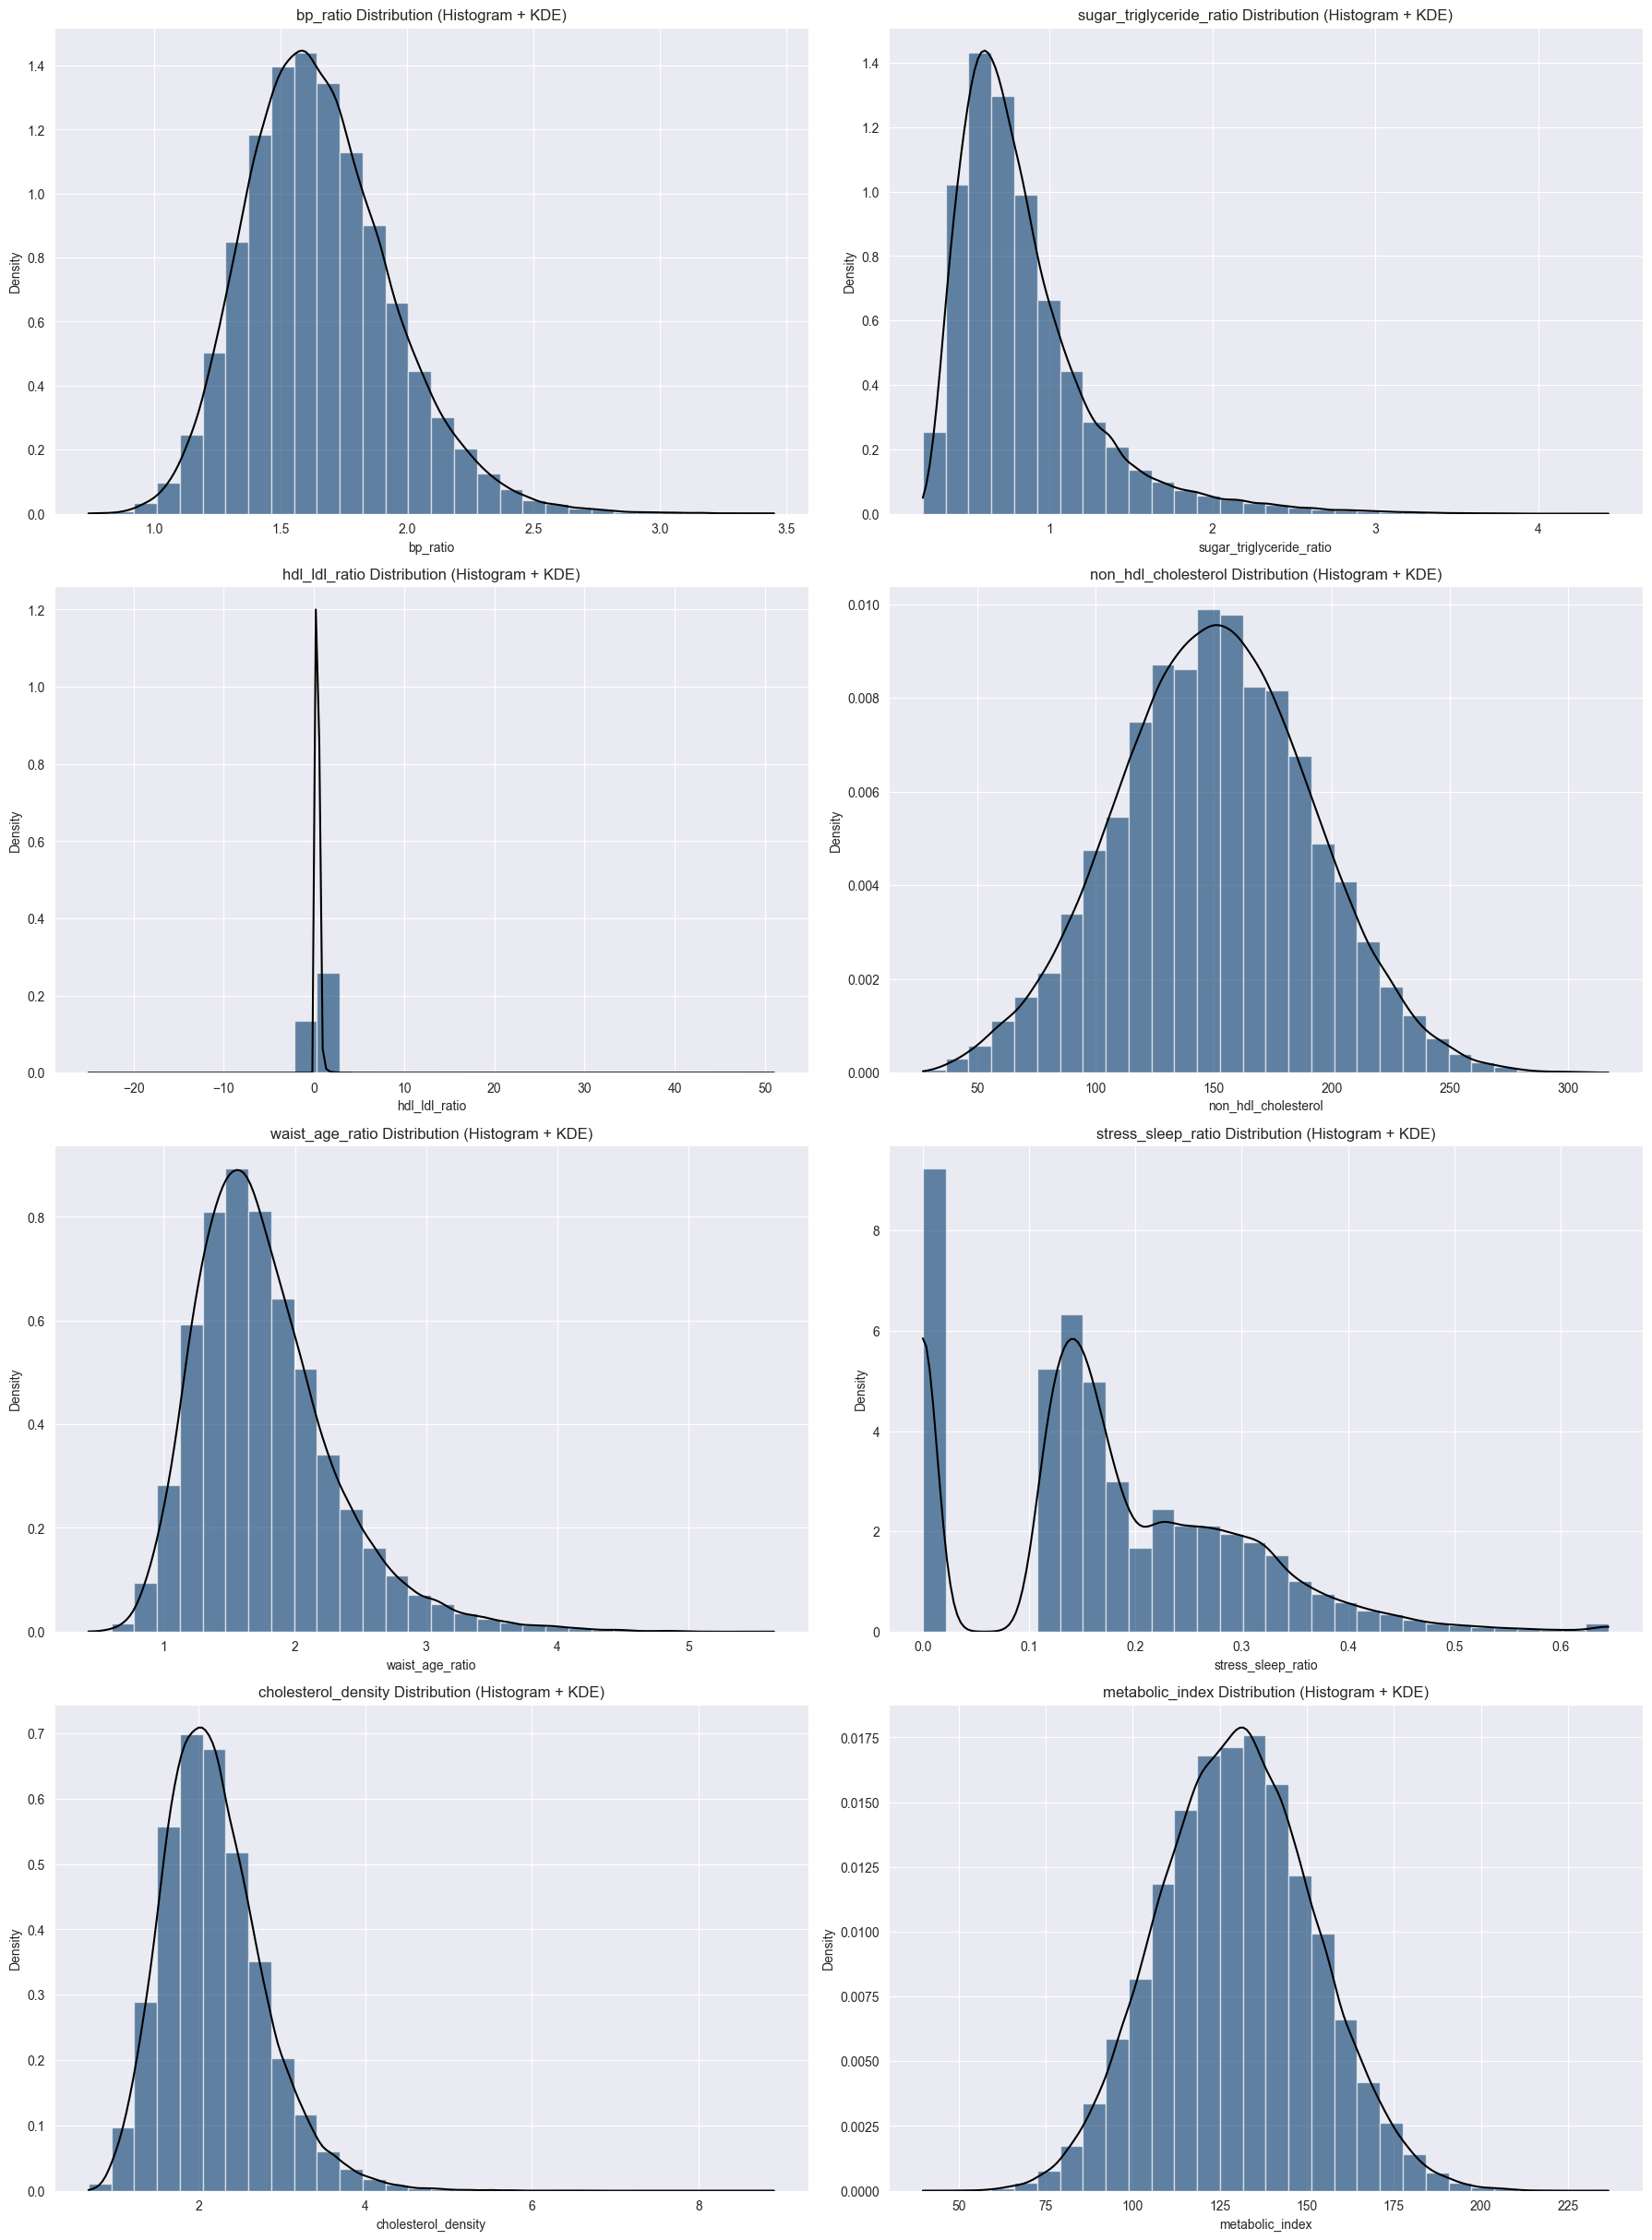

In [12]:
clean_numeric_df = df[numeric_cols].replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(18, 30))

for idx, col in enumerate(derived_cols, 1):
    data = df[col].replace([np.inf, -np.inf], np.nan).dropna()

    plt.subplot(5, 2, idx)
    plt.hist(data, bins=30, color=colors[1], alpha=0.6, density=True)

    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 200)
    plt.plot(x_vals, kde(x_vals), color='black')

    plt.title(f"{col} Distribution (Histogram + KDE)")
    plt.xlabel(col)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

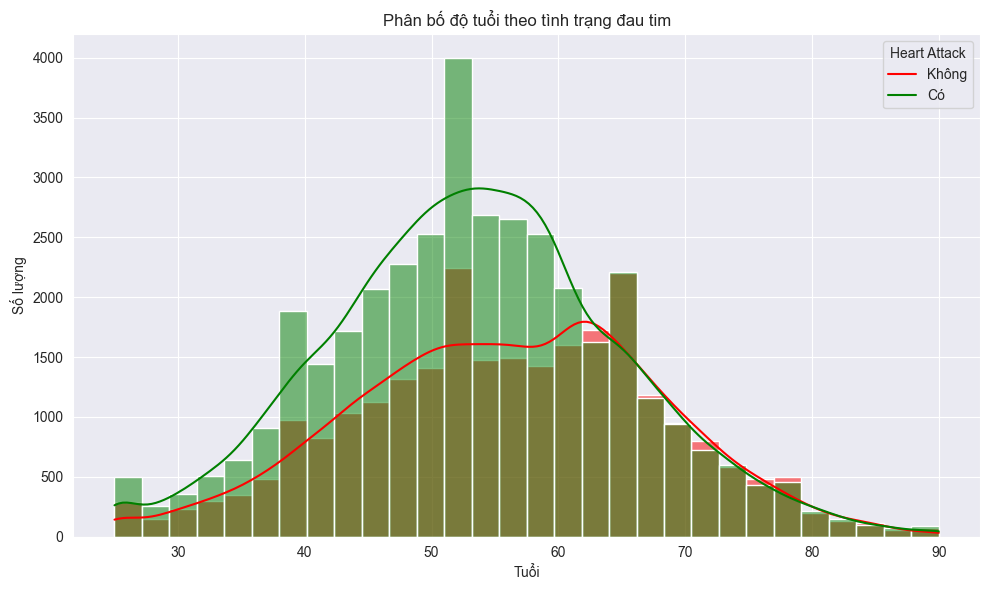

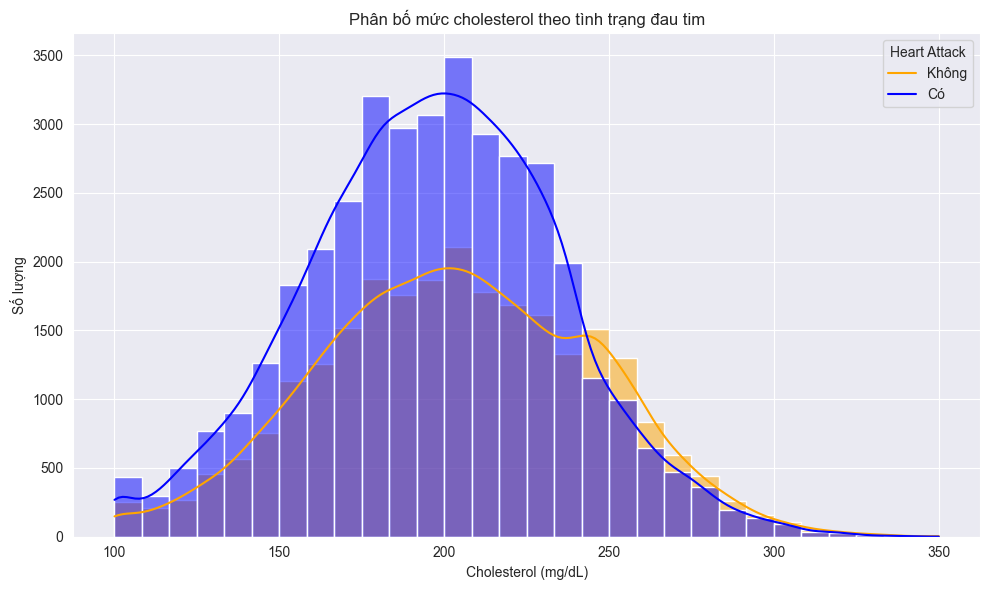

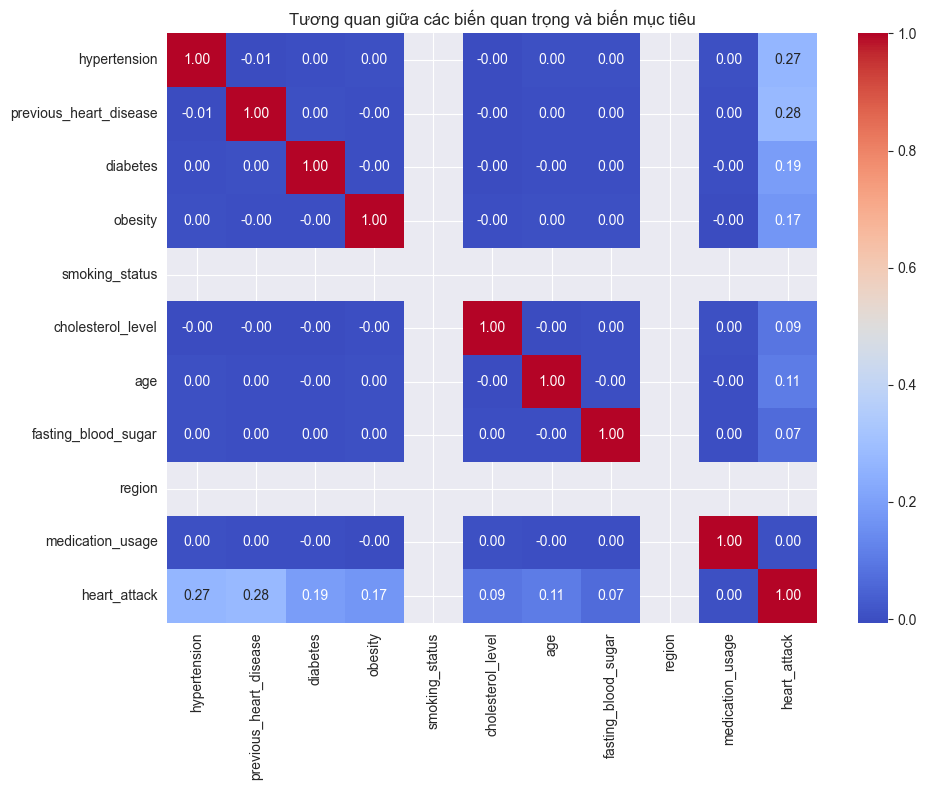

In [13]:


# Plot 1: Phân bố độ tuổi theo tình trạng đau tim
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="age", hue="heart_attack", kde=True, bins=30, palette=["green", "red"])
plt.title("Phân bố độ tuổi theo tình trạng đau tim")
plt.xlabel("Tuổi")
plt.ylabel("Số lượng")
plt.legend(title="Heart Attack", labels=["Không", "Có"])
plt.tight_layout()
plt.show()

# Plot 2: Phân bố mức cholesterol theo tình trạng đau tim
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="cholesterol_level", hue="heart_attack", kde=True, bins=30, palette=["blue", "orange"])
plt.title("Phân bố mức cholesterol theo tình trạng đau tim")
plt.xlabel("Cholesterol (mg/dL)")
plt.ylabel("Số lượng")
plt.legend(title="Heart Attack", labels=["Không", "Có"])
plt.tight_layout()
plt.show()

# Plot 3: Tương quan giữa các biến quan trọng và biến mục tiêu
important_features = [
    "hypertension", "previous_heart_disease", "diabetes", "obesity",
    "smoking_status", "cholesterol_level", "age", "fasting_blood_sugar",
    "region", "medication_usage", "heart_attack"
]

# Convert categorical to numeric where needed
df_encoded = df[important_features].copy()
df_encoded["region"] = df_encoded["region"].map({"Urban": 1, "Rural": 0})
df_encoded["smoking_status"] = df_encoded["smoking_status"].map({"Never": 0, "Past": 1, "Current": 2})

# Plot heatmap
plt.figure(figsize=(10, 8))
corr = df_encoded.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Tương quan giữa các biến quan trọng và biến mục tiêu")
plt.tight_layout()
plt.show()


In [14]:
#lựa chọn các biến quan trọng
selected_features = [
    'age', 'gender', 'region', 'income_level', 'hypertension', 'diabetes',
    'cholesterol_level', 'obesity', 'waist_circumference', 'family_history',
    'smoking_status', 'alcohol_consumption', 'physical_activity',
    'dietary_habits', 'air_pollution_exposure', 'stress_level', 'sleep_hours',
    'blood_pressure_systolic', 'blood_pressure_diastolic',
    'fasting_blood_sugar', 'cholesterol_hdl', 'cholesterol_ldl',
    'triglycerides', 'EKG_results', 'previous_heart_disease',
    'medication_usage', 'participated_in_free_screening', 'bp_ratio',
    'sugar_triglyceride_ratio', 'hdl_ldl_ratio', 'non_hdl_cholesterol',
    'waist_age_ratio', 'stress_sleep_ratio', 'metabolic_index',
    'cholesterol_density'
]

In [15]:
X = df[selected_features].copy()
y = df['heart_attack']

In [16]:
# Chọn các cột kiểu số (int64, float64) để xử lý giá trị ngoại lệ và thiếu
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Thay thế các giá trị vô cực (inf, -inf) bằng NaN trong các cột số
X[numeric_cols] = X[numeric_cols].replace([np.inf, -np.inf], np.nan)

# Loại bỏ các hàng có giá trị NaN ở bất kỳ cột số nào
X = X.dropna(subset=numeric_cols)
y = y[X.index]

# Xử lý các giá trị ngoại lai quá lớn (lớn hơn 1e10) bằng cách thay thế bằng NaN
for col in numeric_cols:
    X.loc[X[col] > 1e10, col] = np.nan

# Loại bỏ thêm các hàng có NaN sau khi xử lý ngoại lệ
X = X.dropna(subset=numeric_cols)
y = y[X.index]

# Điền các giá trị NaN còn lại (nếu có) bằng giá trị trung bình của từng cột số
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].mean())

In [17]:
# Lấy các cột kiểu object (chuỗi) để mã hóa One-Hot
cat_cols = X.select_dtypes(include='object').columns.tolist()

# Thiết lập bộ biến đổi (preprocessor): mã hóa biến phân loại, giữ nguyên phần còn lại
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

# Áp dụng biến đổi để mã hóa dữ liệu
X_encoded = preprocessor.fit_transform(X)

# Cân bằng tập dữ liệu bằng kỹ thuật SMOTE (tăng cường lớp thiểu số)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

In [18]:
# Chia tập dữ liệu thành tập huấn luyện và kiểm tra (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42)

In [19]:
# Khởi tạo mô hình XGBoost với random_state cố định để tái lập kết quả
model = XGBClassifier(random_state=42)

# Tập hợp các siêu tham số cần tối ưu hóa bằng RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
}

# Tìm kiếm ngẫu nhiên mô hình tốt nhất với 20 tổ hợp tham số, dùng độ chính xác làm thước đo
random_search = RandomizedSearchCV(
    model, param_distributions=param_dist, n_iter=20,
    scoring='accuracy', cv=3, verbose=1, random_state=42, n_jobs=-1
)
random_search.fit(X_train, y_train)

# Lưu lại mô hình tốt nhất sau tìm kiếm
best_model = random_search.best_estimator_

# Dự đoán xác suất thuộc lớp 1 trên tập kiểm tra
y_proba = best_model.predict_proba(X_test)[:, 1]

# Tìm ngưỡng (threshold) tối ưu để phân loại nhị phân dựa trên độ chính xác cao nhất
best_thresh = 0.5
best_acc = 0
for thresh in np.arange(0.1, 0.9, 0.01):
    y_pred_thresh = (y_proba >= thresh).astype(int)
    acc = accuracy_score(y_test, y_pred_thresh)
    if acc > best_acc:
        best_acc = acc
        best_thresh = thresh

# Dự đoán nhãn đầu ra cuối cùng với ngưỡng phân loại tối ưu
y_pred = (y_proba >= best_thresh).astype(int)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\namvi\PyCharmMiscProject\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\namvi\PyCharmMiscProject\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\namvi\PyCharmMiscProject\.venv\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\namvi\PyCharmMiscProject\.venv\Lib\site-packages\xgboost\sklearn.py", line 1663, in fit
    train_dmatrix, e

Best Threshold: 0.56
Accuracy (XGBoost): 78.01%
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      7578
           1       0.84      0.69      0.76      7537

    accuracy                           0.78     15115
   macro avg       0.79      0.78      0.78     15115
weighted avg       0.79      0.78      0.78     15115

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         6566         1012
Actual 1         2312         5225


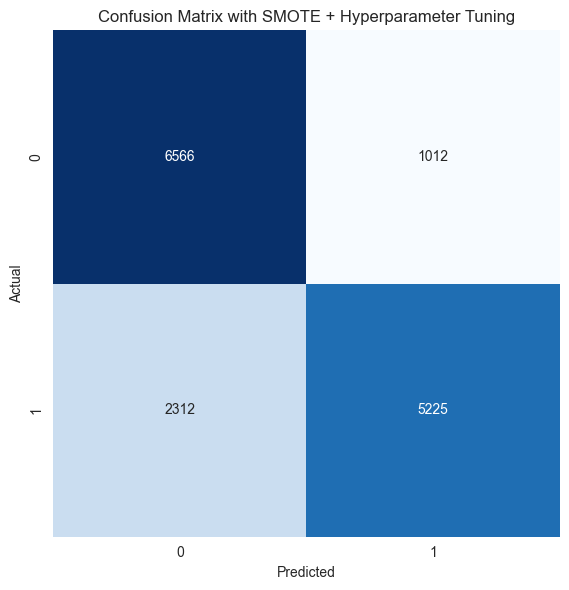

In [20]:
print(f"Best Threshold: {round(best_thresh, 2)}")
accuracy_percent = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy (XGBoost): {accuracy_percent:.2f}%")

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1']))


plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix with SMOTE + Hyperparameter Tuning")
plt.tight_layout()
plt.show()

Best Threshold (Random Forest): 0.52
Accuracy (Random Forest): 77.47%
Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      7578
           1       0.80      0.73      0.76      7537

    accuracy                           0.77     15115
   macro avg       0.78      0.77      0.77     15115
weighted avg       0.78      0.77      0.77     15115

Confusion Matrix (Random Forest):
          Predicted 0  Predicted 1
Actual 0         6187         1391
Actual 1         2015         5522


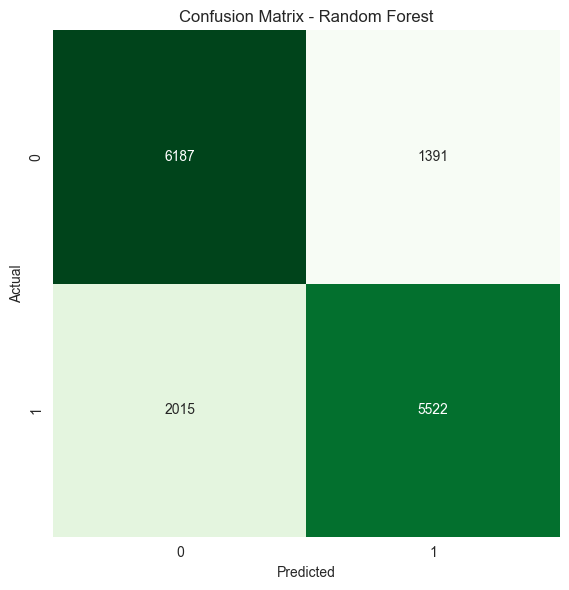

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Chia tập dữ liệu
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# 2. Khởi tạo mô hình Random Forest
rf_model = RandomForestClassifier(random_state=42)

# 3. Huấn luyện mô hình
rf_model.fit(X_train, y_train)

# 4. Dự đoán xác suất để tìm ngưỡng tối ưu
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# 5. Tìm ngưỡng dự đoán tốt nhất
best_thresh_rf = 0.5
best_acc_rf = 0

for thresh in np.arange(0.1, 0.9, 0.01):
    y_pred_thresh = (y_proba_rf >= thresh).astype(int)
    acc = accuracy_score(y_test, y_pred_thresh)
    if acc > best_acc_rf:
        best_acc_rf = acc
        best_thresh_rf = thresh

# 6. Dự đoán nhị phân theo ngưỡng tốt nhất
y_pred_rf = (y_proba_rf >= best_thresh_rf).astype(int)

# 7. Đánh giá mô hình
print(f"Best Threshold (Random Forest): {round(best_thresh_rf, 2)}")
accuracy_percent = accuracy_score(y_test, y_pred_rf) * 100
print(f"Accuracy (Random Forest): {accuracy_percent:.2f}%")
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

# 8. Ma trận nhầm lẫn
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix (Random Forest):")
print(pd.DataFrame(cm_rf, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1']))



# 9. Vẽ biểu đồ heatmap cho confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False, square=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()


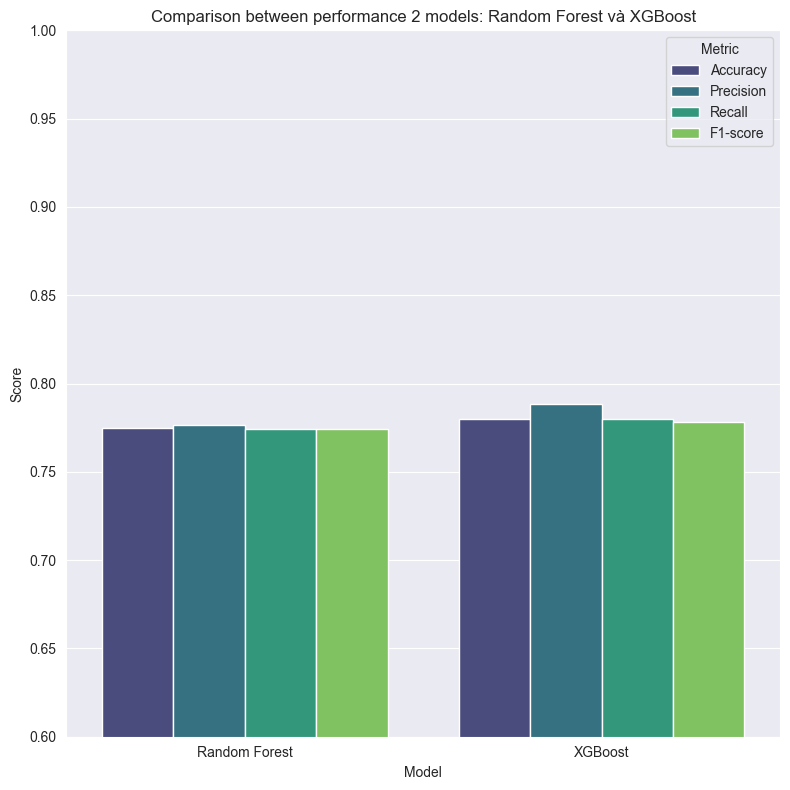

In [28]:
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Accuracy riêng biệt
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_xgb = accuracy_score(y_test, y_pred)

# Classification report
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
report_xgb = classification_report(y_test, y_pred, output_dict=True)

# Lấy các chỉ số macro avg
rf_metrics = {
    'Model': 'Random Forest',
    'Accuracy': acc_rf,
    'Precision': report_rf['macro avg']['precision'],
    'Recall': report_rf['macro avg']['recall'],
    'F1-score': report_rf['macro avg']['f1-score']
}

xgb_metrics = {
    'Model': 'XGBoost',
    'Accuracy': acc_xgb,
    'Precision': report_xgb['macro avg']['precision'],
    'Recall': report_xgb['macro avg']['recall'],
    'F1-score': report_xgb['macro avg']['f1-score']
}

# Tạo DataFrame từ 2 dict
df_metrics = pd.DataFrame([rf_metrics, xgb_metrics])

# Chuyển sang long-form để vẽ biểu đồ
df_long = pd.melt(df_metrics, id_vars='Model', var_name='Metric', value_name='Score')

# Vẽ biểu đồ
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.barplot(data=df_long, x='Model', y='Score', hue='Metric', palette='viridis')

plt.title('Comparison between performance 2 models: Random Forest và XGBoost')
plt.ylim(0.6, 1.0)
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


In [23]:
import streamlit as st
st.write("hoang")

2025-06-12 23:44:02.610 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 23:44:02.613 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
